# PokerML

In [15]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [16]:
import numpy as np

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical

Make sure that you have Vivado suite in your environment.

In [17]:
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Configuration

In [43]:
DATA_DIR = "data"

MODELS_DIR = 'models/'
DATA_NPY_DIR = DATA_DIR + '/npy/'

IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
TEST_SIZE = 0.2
NUM_CLASSES = 52

# CREATE_DATASET = True
KERAS_TRAIN = False
QKERAS_TRAIN = True

## Load data

In [19]:
X_train_val = np.load(DATA_NPY_DIR + 'X_train_val.npy')
X_test = np.load(DATA_NPY_DIR + 'X_test.npy')
y_train_val = np.load(DATA_NPY_DIR + 'y_train_val.npy')
y_test = np.load(DATA_NPY_DIR + 'y_test.npy')
classes = np.load(DATA_NPY_DIR + 'classes.npy', allow_pickle=True)

In [20]:
print('Train and validation set:', X_train_val.shape[0])
print('Test set:                ', X_test.shape[0])
print('Classes:                 ', classes.shape[0])

Train and validation set: 19968
Test set:                 4992
Classes:                  52


## Train Keras model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [22]:
if KERAS_TRAIN:
    model = Sequential()
    model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool1'))
    model.add(Conv2D(8, (3, 3), activation='relu', name='conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(32, activation='relu', name='dense1'))
    model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))
    
    print("Model summary:")
    model.summary()

In [40]:
if KERAS_TRAIN:
    adam = Adam(lr=0.01)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir=MODELS_DIR+'/keras',
    )
    history = model.fit(
        X_train_val,
        y_train_val,
        batch_size=10,
        epochs=50,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )

else:
    from tensorflow.keras.models import load_model

    model = load_model(MODELS_DIR + 'keras/check_best_model.h5')
    
    print("Model summary:")
    model.summary()

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 62, 4)         112       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 31, 31, 4)         0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 8)         296       
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense1 (Dense)              (None, 32)                50208     
                                                                 
 output (Dense)              (None, 52)  

In [24]:
if KERAS_TRAIN:
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [41]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)

print("Keras accuracy: {:.6f}%".format(100.0 * accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

#plt.figure(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_keras, label_encoder.classes_)

156/156 [==============================] - 2s 10ms/step
Keras accuracy: 73.096955%


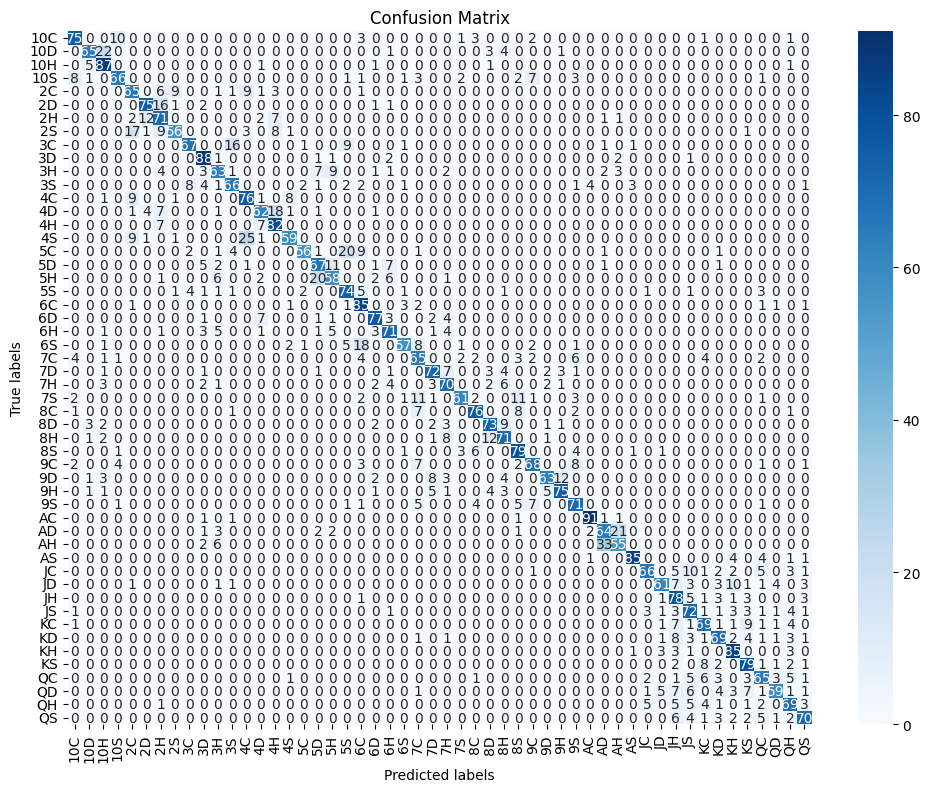

In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.
    
    Args:
        cm (array, shape = [n, n]): Confusion matrix
        class_names (array, shape = [n]): Array of class names
    """
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

y_test_ = np.argmax(y_test, axis=1)
y_keras_ = np.argmax(y_keras, axis=1)

cm = confusion_matrix(y_test_, y_keras_)

plot_confusion_matrix(cm, classes)

## Keras to hls4ml (Post Training Quantization)

In [28]:
!mkdir -p projects

In [29]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='projects/ptq_hls4ml_prj', part='xcu250-figd2104-2L-e'
)

/home/esp2024/rht2122/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
-----------------------------------
Configuration
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Stra

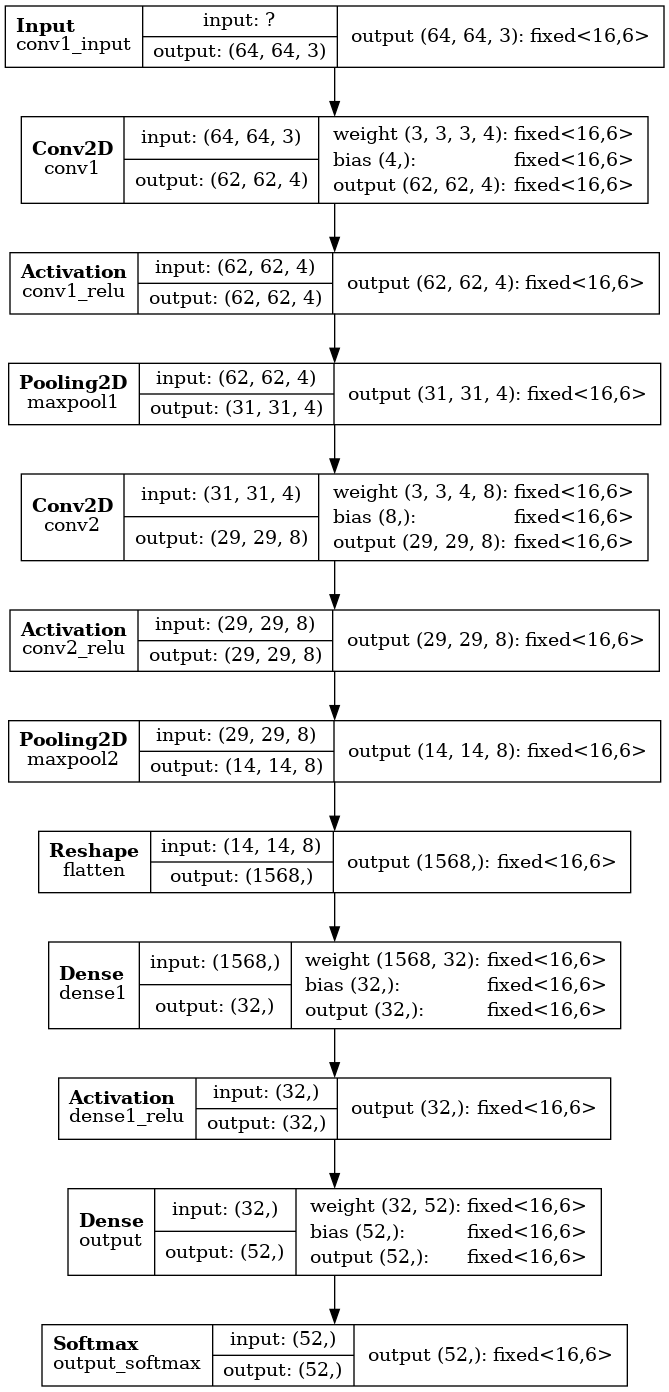

In [30]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

The following cell takes approx. 5 minutes. It tries to compile the weights in the header files, while it should load them on the run. Not big issue, but annoying.

In [31]:
hls_model.compile()

Writing HLS project
Done


In [32]:
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

print("Keras  accuracy: {:.6f}".format(100.*accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml accuracy: {:.6f}".format(100.*accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

KeyboardInterrupt: 

In [ ]:
y_test_ = np.argmax(y_test, axis=1)
y_hls_ = np.argmax(y_hls, axis=1)

cm = confusion_matrix(y_test_, y_hls_)

plot_confusion_matrix(cm, classes)

## Train QKeras model

In [44]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras import QDense, QActivation, QConv2D
from qkeras.quantizers import quantized_bits, quantized_relu

In [46]:
model = Sequential()
model.add(QConv2D(4,
                 (3, 3),
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                 kernel_quantizer=quantized_bits(6),
                 bias_quantizer=quantized_bits(6), 
                 name='conv1'))
model.add(QActivation(activation=quantized_relu(6),
                      name='relu1'))
model.add(MaxPooling2D(pool_size=(2, 2),
                       name='maxpool1'))
model.add(QConv2D(8,
                 (3, 3),
                 kernel_quantizer=quantized_bits(6),
                 bias_quantizer=quantized_bits(6), 
                 name='conv2'))
model.add(QActivation(activation=quantized_relu(6),
                      name='relu2'))
model.add(MaxPooling2D(pool_size=(2, 2),
                       name='maxpool2'))
model.add(Flatten(name='flatten'))
model.add(QDense(32,
                 kernel_quantizer=quantized_bits(6),
                 bias_quantizer=quantized_bits(6), 
                 name='dense1'))
model.add(QActivation(activation=quantized_relu(6),
                      name='relu3'))
model.add(QDense(NUM_CLASSES,
                 kernel_quantizer=quantized_bits(6),
                 bias_quantizer=quantized_bits(6), 
                 activation='softmax',
                 name='output'))

In [47]:
if QKERAS_TRAIN:
    adam = Adam(lr=0.001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir=MODELS_DIR + 'qkeras',
    )
    history = model.fit(
        X_train_val,
        y_train_val,
        batch_size=10,
        epochs=50,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )

else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    
    model = load_model(MODELS_DIR + 'qkeras/check_best_model.h5')

Epoch 1/50
1497/1498 [============================>.] - ETA: 0s - loss: 3.4353 - accuracy: 0.1299
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 1: val_loss improved from inf to 2.91949, saving model to models/qkeras/check_best_model.h5

Epoch 1: val_loss improved from inf to 2.91949, saving model to models/qkeras/check_best_model_weights.h5

Epoch 1: saving model to models/qkeras/check_model_last.h5

Epoch 1: saving model to models/qkeras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 33s 20ms/step - loss: 3.4351 - accuracy: 0.1300 - val_loss: 2.9195 - val_accuracy: 0.2420 - lr: 0.0010
Epoch 2/50
1496/1498 [============================>.] - ETA: 0s - loss: 2.6114 - accuracy: 0.3213
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 2: val_loss improved from 2.91949 to 2.33564, saving model to models/qkeras/check_best_model.h5

Epoch 2: val_loss improved from 2.91949 to 2.33564, saving model to models/qkera


Epoch 13: val_loss improved from 1.27886 to 1.24138, saving model to models/qkeras/check_best_model_weights.h5

Epoch 13: saving model to models/qkeras/check_model_last.h5

Epoch 13: saving model to models/qkeras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 26s 17ms/step - loss: 0.9408 - accuracy: 0.7802 - val_loss: 1.2414 - val_accuracy: 0.6532 - lr: 0.0010
Epoch 14/50
1497/1498 [============================>.] - ETA: 0s - loss: 0.9004 - accuracy: 0.7926
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 14: val_loss did not improve from 1.24138

Epoch 14: val_loss did not improve from 1.24138

Epoch 14: saving model to models/qkeras/check_model_last.h5

Epoch 14: saving model to models/qkeras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 26s 18ms/step - loss: 0.9004 - accuracy: 0.7926 - val_loss: 1.2539 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 15/50
1498/1498 [==========


Epoch 26: saving model to models/qkeras/check_model_last.h5

Epoch 26: saving model to models/qkeras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 26s 17ms/step - loss: 0.6168 - accuracy: 0.8794 - val_loss: 1.1413 - val_accuracy: 0.6785 - lr: 0.0010
Epoch 27/50
1498/1498 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.8781
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 27: val_loss did not improve from 1.12363

Epoch 27: val_loss did not improve from 1.12363

Epoch 27: saving model to models/qkeras/check_model_last.h5

Epoch 27: saving model to models/qkeras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 27s 18ms/step - loss: 0.6105 - accuracy: 0.8781 - val_loss: 1.2014 - val_accuracy: 0.6542 - lr: 0.0010
Epoch 28/50
1495/1498 [============================>.] - ETA: 0s - loss: 0.6013 - accuracy: 0.8801
***callbacks***
saving losses to models/qkeras


Epoch 40: saving model to models/qkeras/check_model_epoch40.h5

***callbacks end***

1498/1498 [==============================] - 26s 17ms/step - loss: 0.5122 - accuracy: 0.9113 - val_loss: 1.2597 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 41/50
1496/1498 [============================>.] - ETA: 0s - loss: 0.4994 - accuracy: 0.9132
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 41: val_loss did not improve from 1.10475

Epoch 41: val_loss did not improve from 1.10475

Epoch 41: saving model to models/qkeras/check_model_last.h5

Epoch 41: saving model to models/qkeras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 26s 17ms/step - loss: 0.4993 - accuracy: 0.9133 - val_loss: 1.1225 - val_accuracy: 0.6803 - lr: 0.0010
Epoch 42/50
1496/1498 [============================>.] - ETA: 0s - loss: 0.4973 - accuracy: 0.9139
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 42: val_loss improved from 1.10475 to 1.08735, 

In [48]:
if KERAS_TRAIN:
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [49]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))

print("QKeras accuracy: {:.6f}%".format(100.*accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))

156/156 [==============================] - 3s 14ms/step
QKeras accuracy: 67.888622%


## QKeras to hls4ml (Quantization Aware Training)

In [50]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['output']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['output']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

config['Model']['ReuseFactor'] = 256

hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='projects/qat_hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: QConv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: relu1, layer type: Activation, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: QConv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: relu2, layer type: Activation, input shapes: [[None, 29, 29, 8]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: QDense, input shapes: [[None, 1568]], output shape

The following cell takes approx. 5 minutes. It tries to compile the weights in the header files, while it should load them on the run. Not big issue, but annoying.

In [51]:
hls_model.compile()

Writing HLS project
Done


In [52]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))
#np.save('model_2/y_qkeras.npy', y_qkeras)
#np.save('model_2/y_hls.npy', y_hls)

156/156 [==============================] - 2s 14ms/step


In [53]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

print("Accuracy baseline:  {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy quantized: {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml:    {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

Accuracy baseline:  0.730970%
Accuracy quantized: 0.678886%
Accuracy hls4ml:    0.650841%


In [54]:
# fig, ax = plt.subplots(figsize=(9, 9))
# _ = plotting.makeRoc(y_test, y_ref, classes)
# plt.gca().set_prop_cycle(None)  # reset the colors
# _ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--')
# plt.gca().set_prop_cycle(None)  # reset the colors
# _ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':')

# from matplotlib.lines import Line2D

# lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
# from matplotlib.legend import Legend

# leg = Legend(ax, lines, labels=['baseline', 'quantized', 'hls4ml'], loc='lower right', frameon=False)
# ax.add_artist(leg)

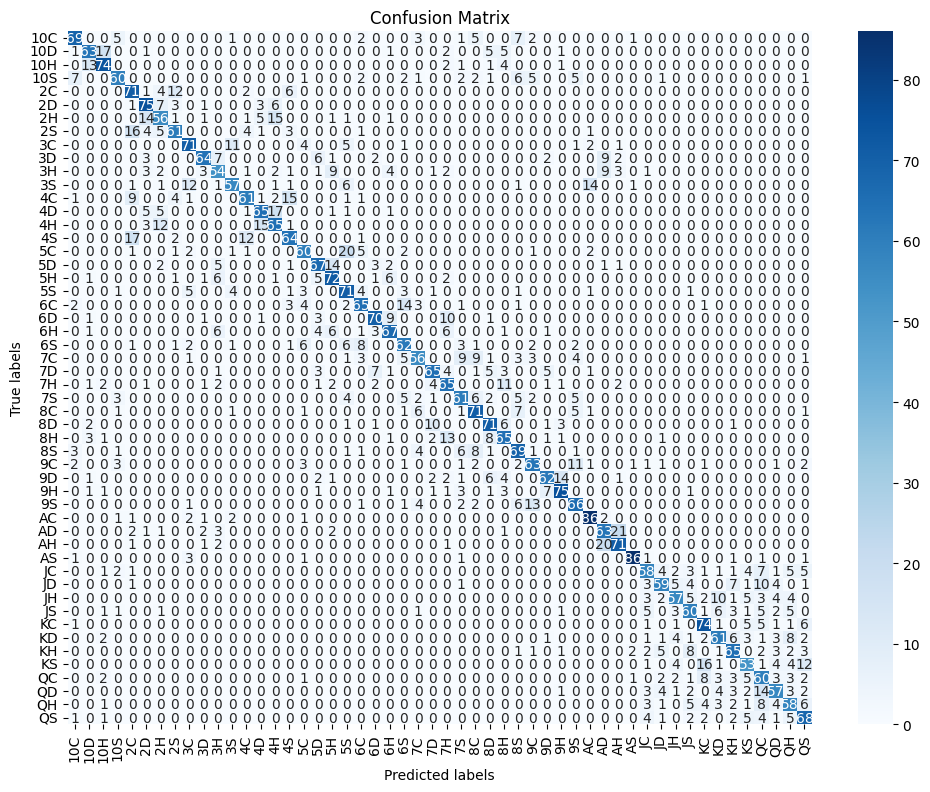

In [55]:
y_test_ = np.argmax(y_test, axis=1)
y_qkeras_ = np.argmax(y_qkeras, axis=1)

cm = confusion_matrix(y_test_, y_qkeras_)

plot_confusion_matrix(cm, classes)

In [ ]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rht2122' on host 'socp06-ubuntu.c.psyched-span-141520.internal' (Linux_x86_64 version 5.4.0-1106-gcp) on Thu Mar 28 01:01:15 UTC 2024
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/esp2024/rht2122/PokerML/PokerML/projects/qat_hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/esp2024/rht2122/PokerML/PokerML/projects/qat_hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project

INFO: [XFORM 203-603] Inlining function 'nnet::conv_2d_latency_cl<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' into 'nnet::conv_2d_cl<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_conv2d.h:50).
INFO: [XFORM 203-603] Inlining function 'nnet::product::weight_exponential<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, exponent_scale17_t>::product' into 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config17>' (firmware/nnet_utils/nnet_batchnorm.h:59).
INFO: [XFORM 203-603] Inlining function 'nnet::dense<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' into 'myproject' (firmware/myproject.cpp:82).
INFO: [XFORM 203-603] Inlining function 'nnet::product::weight_exponential<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, expon

In [ ]:
hls4ml.report.read_vivado_report('projects/qat_hls4ml_prj')